# Self Driving Car Perception
This self driving car uses the Inference Engine included in the Intel® Distribution of OpenVINO™ toolkit and the Intel® Deep Learning Deployment Toolkit. It is designed for a car mounted camera system that detects the driving lane and other vehicle along the road. It is intended to provide real-time car perception, mainly localization, to the self-driving car control system.

## Overview of how it works
At start-up the sample application reads the equivalent of command line arguments and loads a network and image from the video input to the Inference Engine (IE) plugin. A job is submitted to an edge compute node with a hardware accelerator such as Intel® HD Graphics GPU, Intel® Movidius™ Neural Compute Stick 2 and Intel® Arria® 10 FPGA. After the inference is completed, the output videos are appropriately stored in the /results/[device] directory, which can then be viewed within the Jupyter Notebook instance.

## Demonstration objectives

This is a demo project implementation to find the inference delay using Intel Hardware/Software combination.

This demo showcases:
#### Video input support and pre-processing for different models using OpenCV
#### Multiple model deployment
Vehicle detection and road segmentation
#### Inference performance on edge hardware
Inference performend using OpenVINO on an edge compute node with a hardware accelerator such as Intel® HD Graphics GPU, Intel® Movidius™ Neural Compute Stick 2 and Intel® Arria® 10 FPGA
#### Async API in action
Improving the overall frame-rate of the application by not waiting for the inference to complete but continuing to do things on the host while inference accelerator is busy.
#### Output processing using OpenCV
- **Vehicle detection** Bounding boxes, labels, box colors, confidence threshold, etc.
- **Road Segmentation** Semantic mask for the road (purple)

#### Lane detection
Based on the road marks detected by road segmenation model, an image processing flow for lane detection is implemented using OpenCV.

[Details in demo_util.py]

#### Visualization
Visualizing the road mask, the vehicles' bounding boxes and detected lane lines.




## Step 0: Set Up

### 0.1: Import dependencies

Run the below cell to import Python dependencies needed for displaying the results in this notebook

In [1]:
from IPython.display import HTML
import matplotlib.pyplot as plt
import os
import time
import sys
from qarpo.demoutils import *

### 0.2 (Optional\-step): Original video without inference

If you are curious to see the input video, run the following cell to view a short clip of the original video stream used for inference. 

In [2]:
videoHTML('Road video', ['Resources/test_video.mp4'])

Some of these downloaded models are already in the IR format, while others will require the model optimizer. In this demo, we will be using the **vehicle-detection-adas-0002** and **road-segmentation-adas-0001** model, which is already in IR format. This model can be downloaded with the following command.

In [4]:
!/opt/intel/openvino/deployment_tools/tools/model_downloader/downloader.py --name vehicle-detection-adas-0002 -o models --progress_format text
!/opt/intel/openvino/deployment_tools/tools/model_downloader/downloader.py --name road-segmentation-adas-0001 -o models --progress_format text

################|| Downloading models ||################

========== Downloading models/intel/vehicle-detection-adas-0002/FP32/vehicle-detection-adas-0002.xml
... 100%, 210 KB, 3378 KB/s, 0 seconds passed

========== Downloading models/intel/vehicle-detection-adas-0002/FP32/vehicle-detection-adas-0002.bin
... 100%, 4213 KB, 10990 KB/s, 0 seconds passed

========== Downloading models/intel/vehicle-detection-adas-0002/FP16/vehicle-detection-adas-0002.xml
... 100%, 210 KB, 19822 KB/s, 0 seconds passed

========== Downloading models/intel/vehicle-detection-adas-0002/FP16/vehicle-detection-adas-0002.bin
... 100%, 2106 KB, 11175 KB/s, 0 seconds passed

========== Downloading models/intel/vehicle-detection-adas-0002/FP32-INT8/vehicle-detection-adas-0002.xml
... 100%, 428 KB, 12491 KB/s, 0 seconds passed

========== Downloading models/intel/vehicle-detection-adas-0002/FP32-INT8/vehicle-detection-adas-0002.bin
... 100%, 4286 KB, 10410 KB/s, 0 seconds passed

################|| Post-processing |

The input arguments are as follows:

* --name : name of the model you want to download. It should be one of the models listed in the previous cell
* -o : output directory. If this directory does not exist, it will be created for you.

With the `-o` option set as above, this command downloads the model in the directory `models`, with the model files (.xml and .bin) located at `models/intel/road-segmentation-adas-0001/FP32/` and `models/intel/vehicle-detection-adas-0002/FP32/` .

## Step 2 : Inference on a video
The inference code is already implemented in **CarPerception.py**.

The Python code takes in command line arguments for video, model etc.

**Command line argument options and how they are interpreted in the application source code**

In [5]:
!python3 CarPerception.py -h

usage: CarPerception.py [-h] -m MODEL -rm ROADMODEL -i INPUT
                        [-l CPU_EXTENSION] [-d DEVICE] [-o OUTPUT_DIR]
                        [-n NUM_REQUESTS]

optional arguments:
  -h, --help            show this help message and exit
  -m MODEL, --model MODEL
                        Path to an .xml file with a pre-trained vehicle
                        detection model
  -rm ROADMODEL, --roadmodel ROADMODEL
                        Path to an .xml file with a pre-trained model road
                        segmentation model
  -i INPUT, --input INPUT
                        Path to video file or image.
  -l CPU_EXTENSION, --cpu_extension CPU_EXTENSION
                        MKLDNN (CPU)-targeted custom layers. Absolute path to
                        a shared library with the kernels impl.
  -d DEVICE, --device DEVICE
                        Specify the target device to infer on; CPU, GPU, FPGA
                        or MYRIAD is acceptable. Looksfor a suitable plugin


## The description of the arguments used in the argument parser:
* -m location of the pre-trained IR model which has been pre-processed using the model optimizer. There is automated support built in this argument to support both FP32 and FP16 models targeting different hardware for vehicle detection
* -rm location of the pre-trained IR model which has been pre-processed using the model optimizer. There is automated support built in this argument to support both FP32 and FP16 models targeting different hardware for road segmentation

* -i location of the input video stream

* -o location where the output file with inference needs to be stored (results/[device])
* -d type of Hardware Acceleration (CPU, GPU, MYRIAD, HDDL or HETERO:FPGA,CPU)
* -n Number of inference requests running in parallel

### 2.1 Creating job file
To run inference on the video, we need more compute power. We will run the workload on several edge compute nodes represented in the IoT DevCloud. We will send work to the edge compute nodes by submitting the corresponding non-interactive jobs into a queue. For each job, we will specify the type of the edge compute server that must be allocated for the job.

The job file is written in Bash, and will be executed directly on the edge compute node. Run the following cell to write the job file in to the file "car_perception_job.sh"

In [6]:
%%writefile car_perception_job.sh

#The default path for the job is your home directory, so we change directory to where the files are.
#SAMPLEPATH= '/home/u37265/My-Notebooks/Car_Perception'
cd $PBS_O_WORKDIR

#shopper_monitor_job script writes output to a file inside a directory. We make sure that this directory exists.
#The output directory is the first argument of the bash script
mkdir -p $1
OUTPUT_FILE=$1
DEVICE=$2
FP_MODEL=$3
INPUT_FILE=$4
NUM_INFER_REQS=$5

if [ "$DEVICE" = "HETERO:FPGA,CPU" ]; then
    # Environment variables and compilation for edge compute nodes with FPGAs - Updated for OpenVINO 2020.1
    source /opt/altera/aocl-pro-rte/aclrte-linux64/init_opencl.sh
    export LD_LIBRARY_PATH=${LD_LIBRARY_PATH}:/opt/intel/openvino/bitstreams/a10_vision_design_sg1_bitstreams/BSP/a10_1150_sg1/linux64/lib
    aocl program acl0 /opt/intel/openvino/bitstreams/a10_vision_design_sg1_bitstreams/2019R4_PL1_FP16_MobileNet_Clamp.aocx
    export CL_CONTEXT_COMPILER_MODE_INTELFPGA=3
fi

SAMPLEPATH=${PBS_O_WORKDIR}
echo ${SAMPLEPATH}
if [ "$FP_MODEL" = "FP32" ]; then
  MODELPATH=${SAMPLEPATH}/models/intel/vehicle-detection-adas-0002/FP32/vehicle-detection-adas-0002.xml
else
  MODELPATH=${SAMPLEPATH}/models/intel/vehicle-detection-adas-0002/FP16/vehicle-detection-adas-0002.xml
fi

if [ "$FP_MODEL" = "FP32" ]; then
  ROAD_MODEL=${SAMPLEPATH}/models/intel/road-segmentation-adas-0001/FP32/road-segmentation-adas-0001.xml
else
  ROAD_MODEL=${SAMPLEPATH}/models/intel/road-segmentation-adas-0001/FP16/road-segmentation-adas-0001.xml
fi

#Running the code
python3 CarPerception.py        -m ${MODELPATH} \
                                -i ${INPUT_FILE} \
                                -o ${OUTPUT_FILE} \
                                -d ${DEVICE} \
                                -rm ${ROAD_MODEL}\
                                -n $NUM_INFER_REQS

Writing car_perception_job.sh


### 2.2 Job submission into the queue
Now that we have the job script, we can submit the jobs to edge compute nodes. 
In the IoT DevCloud, you can do this using the `qsub` command. The following cells shows the output video after running on a CPU device using 4 inference requests. We will see later how the performance compares across different compute nodes and across different number of inference requests. 

In [7]:
os.environ["VIDEO"] = "Resources/project_video.mp4"

In [8]:
job_id = !qsub car_perception_job.sh -l nodes=1:tank-870:i5-6500te -F "results/demo/ CPU FP32 $VIDEO 4" -N car_perception
print(job_id[0]) 
if job_id:
    progressIndicator('results/demo/', 'i_progress_'+job_id[0]+'.txt', "Inference", 0, 100)

5080.v-qsvr-1.devcloud-edge


### Output Video
The output video is created at ['results/demo/road.mp4']. The video shows the **average inference delay time** for each at the top left corner of the frame. 

In [10]:
videoHTML('Road video', ['results/demo/road.mp4'],'results/demo/stats.txt')

### 2.3 Number of inference requests
In the cell below, we submit jobs with different number of inference requests to an IEI Tank* 870-Q170 edge node with an Intel® Core™ i5-6500TE processor. The inference workload will run on the CPU.

In [12]:
#Submit job to the queue
job_id_core1 = !qsub car_perception_job.sh -l nodes=1:tank-870:i5-6500te -F "results/core1/ CPU FP32 $VIDEO 1" -N car_perception_core1
print(job_id_core1[0]) 

#Progress indicators
if job_id_core1:
    progressIndicator('results/core1/', 'i_progress_'+job_id_core1[0]+'.txt', "Inference", 0, 100)
#Submit job to the queue
job_id_core2 = !qsub car_perception_job.sh -l nodes=1:tank-870:i5-6500te -F "results/core2/ CPU FP32 $VIDEO 2" -N car_perception_core2
print(job_id_core2[0]) 

#Progress indicators
if job_id_core2:
    progressIndicator('results/core2/', 'i_progress_'+job_id_core2[0]+'.txt', "Inference", 0, 100)

#Submit job to the queue
job_id_core3 = !qsub car_perception_job.sh -l nodes=1:tank-870:i5-6500te -F "results/core3/ CPU FP32 $VIDEO 3" -N car_perception_core3
print(job_id_core3[0]) 

#Progress indicators
if job_id_core3:
    progressIndicator('results/core3/', 'i_progress_'+job_id_core3[0]+'.txt', "Inference", 0, 100)
    
#Submit job to the queue
job_id_core4 = !qsub car_perception_job.sh -l nodes=1:tank-870:i5-6500te -F "results/core4/ CPU FP32 $VIDEO 4" -N car_perception_core4
print(job_id_core4[0]) 

#Progress indicators
if job_id_core4:
    progressIndicator('results/core4/', 'i_progress_'+job_id_core4[0]+'.txt', "Inference", 0, 100)

5082.v-qsvr-1.devcloud-edge


5083.v-qsvr-1.devcloud-edge


5084.v-qsvr-1.devcloud-edge


5085.v-qsvr-1.devcloud-edge


The running time of each inference task is recorded in `results/core[N]]/stats.txt`. Run the cell below to plot the results of all jobs with different number of inference requests running in parallel. Lower values mean better performance for **Inference Engine Processing Time** .

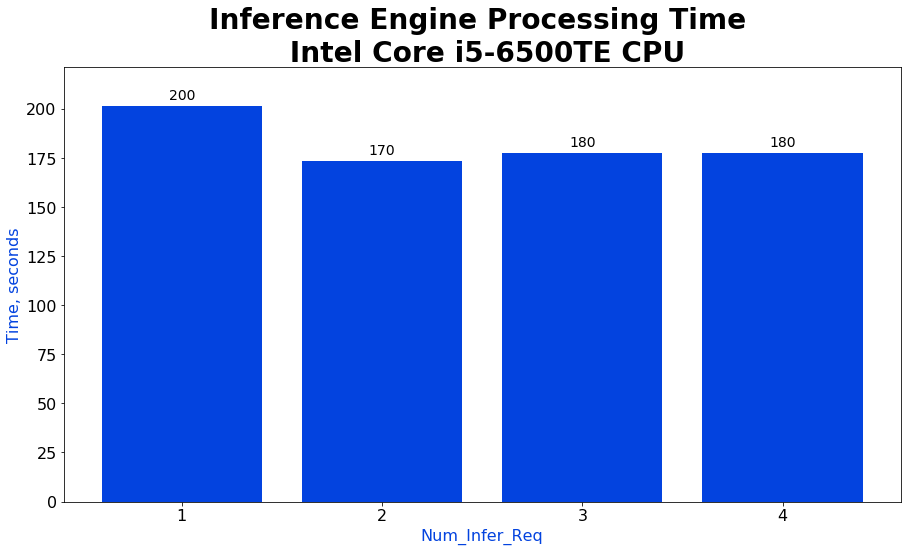

In [31]:
req_list = [('core1', '1'),
             ('core2', '2'),
             ('core3', '3'),
            ('core4', '4')]

stats_list = []
for req, a_name in req_list:
    if 'job_id_'+req in vars():
        stats_list.append(('results/'+req+'/stats'+'.txt', a_name))
    else:
        stats_list.append(('placeholder'+req, a_name))

summaryPlot(stats_list, 'Num_Infer_Req', 'Time, seconds', 'Inference Engine Processing Time \n Intel Core i5-6500TE CPU', 'time' )

#summaryPlot(stats_list, 'Architecture', 'Frames per second', 'Inference Engine FPS', 'fps' )

### 2.4 Different compute nodes
Each of the cells below will submit a job to different edge compute nodes. The output of the cell is the `JobID` of your job, which you can use to track progress of a job.  After submission, they will go into a queue and run as soon as the requested compute resources become available. Note that for some architectures, the FP16 precision models were used instead of the FP32 to further accelerate the inference.

#### Submitting to an edge compute node with an Intel® CPU

In the cell below, we submit a job to an [IEI Tank\* 870\-Q170](https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core) edge node with an [Intel® Core™ i5\-6500TE processor](https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-). The inference workload will run on the CPU.

In [14]:
! rm car_perception_core*
#Submit job to the queue
job_id_core = !qsub car_perception_job.sh -l nodes=1:tank-870:i5-6500te -F "results/core/ CPU FP32 $VIDEO 2" -N car_perception_core
print(job_id_core[0]) 

#Progress indicators
if job_id_core:
    progressIndicator('results/core/', 'i_progress_'+job_id_core[0]+'.txt', "Inference", 0, 100)

rm: cannot remove 'car_perception_core*': No such file or directory
5086.v-qsvr-1.devcloud-edge


#### Submitting to an edge compute node with Intel® Xeon® CPU
In the cell below, we submit a job to an IEI Tank* 870-Q170 edge node with an Intel® Xeon® Processor E3-1268L v5. The inference workload will run on the CPU.

In [19]:
! rm car_perception_xeon.*
#Submit job to the queue
job_id_xeon = !qsub car_perception_job.sh  -l nodes=1:tank-870:e3-1268l-v5 -F "results/xeon/ CPU FP32 $VIDEO 2" -N car_perception_xeon 
print(job_id_xeon[0]) 
#Progress indicators
if job_id_xeon:
    progressIndicator('results/xeon/', 'i_progress_'+job_id_xeon[0]+'.txt', "Inference", 0, 100)

rm: cannot remove 'car_perception_xeon.*': No such file or directory
5087.v-qsvr-1.devcloud-edge


#### Submitting to an edge compute node with Intel® NCS 2 (Neural Compute Stick 2)

In the cell below, we submit a job to an [IEI Tank 870\-Q170](https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core) edge node with an [Intel Core i5\-6500te CPU](https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-). The inference workload will run on an [Intel Neural Compute Stick 2](https://software.intel.com/en-us/neural-compute-stick) installed in this node.

In [20]:
! rm car_perception_ncs2.*
#Submit job to the queue
job_id_ncs2 = !qsub car_perception_job.sh -l nodes=1:tank-870:i5-6500te:intel-ncs2 -F "results/ncs2/ MYRIAD FP16 $VIDEO 2" -N car_perception_ncs2
print(job_id_ncs2[0]) 
#Progress indicators
if job_id_ncs2:
    progressIndicator('results/ncs2/', 'i_progress_'+job_id_ncs2[0]+'.txt', "Inference", 0, 100)

rm: cannot remove 'car_perception_ncs2.*': No such file or directory
5088.v-qsvr-1.devcloud-edge


#### Submitting to an edge compute node with Intel® Core CPU and using the onboard Intel® GPU
In the cell below, we submit a job to an [IEI Tank\* 870\-Q170](https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core) edge node with an [Intel® Core i5\-6500TE](https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-). The inference workload will run on the Intel® HD Graphics 530 card integrated with the CPU.

In [21]:
#Submit job to the queue
job_id_gpu = !qsub car_perception_job.sh -l nodes=1:tank-870:i5-6500te:intel-hd-530 -F "results/gpu/ GPU FP32 $VIDEO 2" -N car_perception_gpu 
print(job_id_gpu[0]) 
#Progress indicators
if job_id_gpu:
    progressIndicator('results/gpu/', 'i_progress_'+job_id_gpu[0]+'.txt', "Inference", 0, 100)

5089.v-qsvr-1.devcloud-edge


#### Submitting to an edge compute node with UP Squared Grove IoT Development Kit (UP2)
In the cell below, we submit a job to an [UP Squared Grove IoT Development Kit](https://software.intel.com/en-us/iot/hardware/up-squared-grove-dev-kit) edge node with an [Intel® Atom® x7\-E3950 Processor](https://ark.intel.com/products/96488/Intel-Atom-x7-E3950-Processor-2M-Cache-up-to-2-00-GHz-). The inference workload will run on the integrated Intel® HD Graphics 505 card. The use of the FP16 model here improved the perfomance from 1.5 fps to 2.4 fps.

In [22]:
#Submit job to the queue
job_id_up2 = !qsub car_perception_job.sh -l nodes=1:up-squared -F "results/up2/ GPU FP16 $VIDEO 4" -N car_perception_up2
print(job_id_up2[0]) 
#Progress indicators
if job_id_up2:
    progressIndicator('results/up2/', 'i_progress_'+job_id_up2[0]+'.txt', "Inference", 0, 100)

5090.v-qsvr-1.devcloud-edge


#### Submitting to an edge compute node with IEI Mustang\-F100\-A10 (Intel® Arria® 10 FPGA)

In the cell below, we submit a job to an [IEI Tank 870\-Q170](https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core) edge node with an [Intel Core™ i5\-6500te CPU](https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-) . The inference workload will run on the [IEI Mustang\-F100\-A10](https://www.ieiworld.com/mustang-f100/en/) card installed in this node.

In [23]:
#Submit job to the queue
job_id_fpga = !qsub car_perception_job.sh -l nodes=1:tank-870:i5-6500te:iei-mustang-f100-a10 -F "results/fpga/ HETERO:FPGA,CPU FP16 $VIDEO 2" -N car_perception_fpga
print(job_id_fpga[0]) 
#Progress indicators
if job_id_fpga:
    progressIndicator('results/fpga/', 'i_progress_'+job_id_fpga[0]+'.txt', "Inference", 0, 100)

5091.v-qsvr-1.devcloud-edge


#### Submitting to an edge compute node with IEI Mustang\-V100\-MX8 (Intel® HDDL\-R)

In [24]:
#Submit job to the queue
job_id_hddlr = !qsub car_perception_job.sh -l nodes=1:idc002mx8:iei-mustang-v100-mx8 -F "results/hddlr/ HDDL FP16 $VIDEO 2" -N car_perception_hddlr
print(job_id_hddlr[0]) 
#Progress indicators
if job_id_hddlr:
    progressIndicator('results/hddlr/', 'i_progress_'+job_id_hddlr[0]+'.txt', "Inference", 0, 100)

5092.v-qsvr-1.devcloud-edge


In [29]:
#liveQstat()
!qstat

Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
5028.v-qsvr-1              ...ub-singleuser u37265          04:13:22 R jupyterhub     


## Step 3: Assess Performance

The running time of each inference task is recorded in `results/[device]/stats.txt`. Run the cell below to plot the results of all jobs side\-by\-side. Lower values mean better performance for **Inference Engine Processing Time** . Keep in mind that some architectures are optimized for the highest performance, others for low power or other metrics.

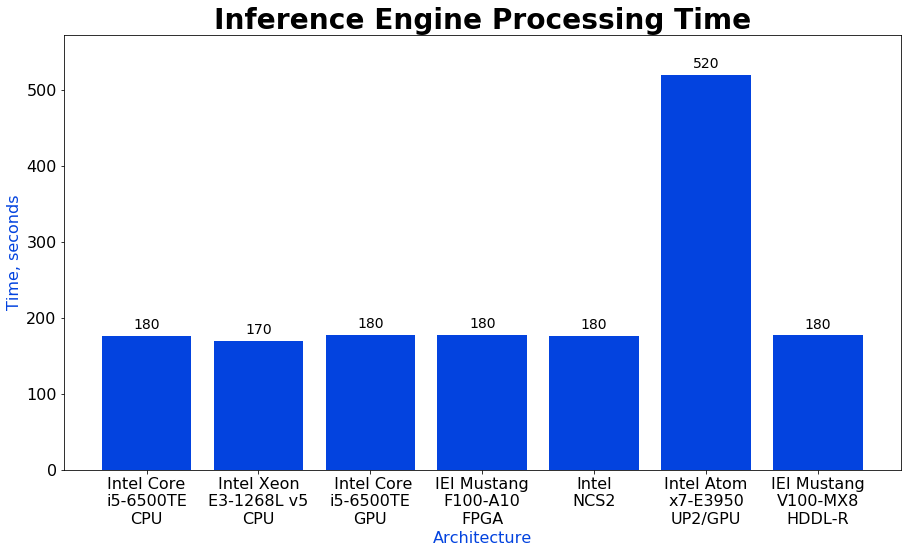

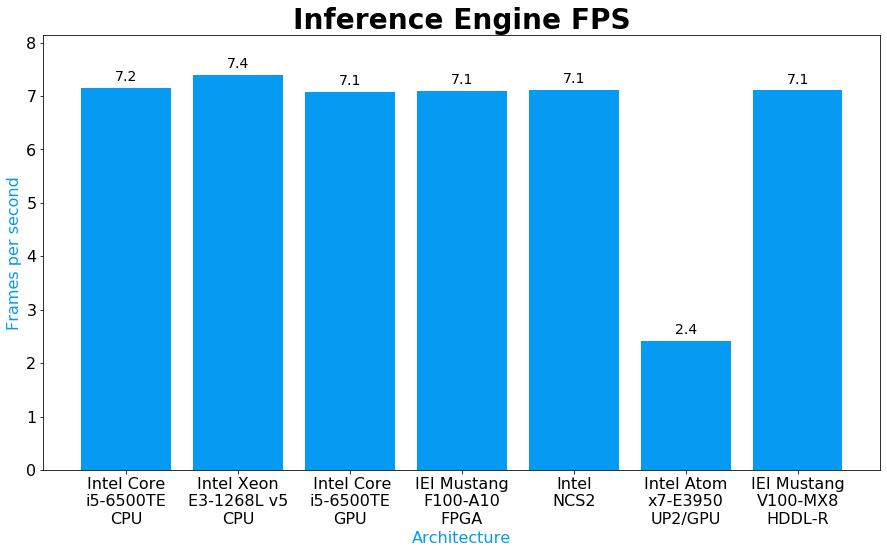

In [30]:
arch_list = [('core', 'Intel Core\ni5-6500TE\nCPU'),
             ('xeon', 'Intel Xeon\nE3-1268L v5\nCPU'),
             ('gpu', ' Intel Core\ni5-6500TE\nGPU'),
             ('fpga', 'IEI Mustang\nF100-A10\nFPGA'),
             ('ncs2', 'Intel\nNCS2'),
             ('up2', 'Intel Atom\nx7-E3950\nUP2/GPU'),
             ('hddlr', 'IEI Mustang\nV100-MX8\nHDDL-R')]

stats_list = []
for arch, a_name in arch_list:
    if 'job_id_'+arch in vars():
        stats_list.append(('results/'+arch+'/stats'+'.txt', a_name))
    else:
        stats_list.append(('placeholder'+arch, a_name))

summaryPlot(stats_list, 'Architecture', 'Time, seconds', 'Inference Engine Processing Time', 'time' )

summaryPlot(stats_list, 'Architecture', 'Frames per second', 'Inference Engine FPS', 'fps' )

In [27]:
#If you are curious to see the available types of nodes on the IoT DevCloud, run the following optional cell.
!pbsnodes | grep compnode | awk '{print $3}' | sort | uniq -c

     43 idc001skl,compnode,iei,tank-870,intel-core,i5-6500te,skylake,intel-hd-530,ram8gb,net1gbe
     13 idc002mx8,compnode,iei,tank-870,intel-core,i5-6500te,skylake,intel-hd-530,ram8gb,net1gbe,hddl-r,iei-mustang-v100-mx8
     17 idc003a10,compnode,iei,tank-870,intel-core,i5-6500te,skylake,intel-hd-530,ram8gb,net1gbe,hddl-f,iei-mustang-f100-a10
     22 idc004nc2,compnode,iei,tank-870,intel-core,i5-6500te,skylake,intel-hd-530,ram8gb,net1gbe,ncs,intel-ncs2
      8 idc006kbl,compnode,iei,tank-870,intel-core,i5-7500t,kaby-lake,intel-hd-630,ram8gb,net1gbe
     12 idc007xv5,compnode,iei,tank-870,intel-xeon,e3-1268l-v5,skylake,intel-hd-p530,ram32gb,net1gbe
     14 idc008u2g,compnode,up-squared,grove,intel-atom,e3950,apollo-lake,intel-hd-505,ram4gb,net1gbe,ncs,intel-ncs2
      1 idc009jkl,compnode,jwip,intel-core,i5-7500,kaby-lake,intel-hd-630,ram8gb,net1gbe
      1 idc010jal,compnode,jwip,intel-atom,e3950,apollo-lake,intel-hd-505,ram4gb,net1gbe
      1 idc011ark2250s,compnode,advantech,intel-